In [2]:
%pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=53c06781e98038133a6fb642ae48f5d846a253fa89c087357ee47ae3241091f7
  Stored in directory: /Users/abdelkrimzitouni/Library/Caches/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
Note: you may need to restart the kernel to use updated packages.


In [16]:
!gunzip -c ./ALOI/aloi-8d.csv.gz > ./ALOI/aloi-8d.csv
!gunzip -c ./ALOI/aloi-haralick-1.csv.gz > ./ALOI/aloi-haralick-1.csv
!gunzip -c ./ALOI/aloi-hsb-2x2x2.csv.gz > ./ALOI/aloi-hsb-2x2x2.csv

In [1]:
import os
import numpy as np
import pandas as pd
import arff

def read_aloi_directory(directory):
    file_list = os.listdir(directory)
    dataset_list = []
    last_column_values = []
    objs = arff.load(open(directory+'/objs.arff'))
    labels = np.array(objs['data'])
    sorted_labels = labels[np.argsort(labels[:, -1].astype(str))]
    sorted_labels[:, :-1] = sorted_labels[:, :-1].astype(float)
    last_column_label_values = sorted_labels[:, -1]
    for file in file_list:
        file_path = os.path.join(directory, file)
        
        if file.endswith('.csv'):
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            df = df.dropna(axis=1, how='all')
            data = df.values
        elif file == "aloi-colorsim77.arff":
            dataset = arff.load(open(file_path))
            data = np.array(dataset['data'])
        else:
            continue
        
        sorted_dataset = data[np.argsort(data[:, -1].astype(str))]
        last_column_values = sorted_dataset[:, -1]
        
        if np.all(last_column_values == last_column_label_values):
            dataset_list.append(sorted_dataset)
    
    dataset_list.append(sorted_labels)
    return dataset_list


In [9]:
aloi = read_aloi_directory('./ALOI')

In [12]:
len(aloi)

5

In [15]:
os.makedirs('aloi_csv', exist_ok=True)
# Save each array as a CSV file
for i, arr in enumerate(aloi):
    df = pd.DataFrame(arr)
    # df = df.apply(pd.to_numeric, errors='ignore')
    arr = df.to_numpy()
    filename = f'aloi_csv/aloi_array_{i}.csv'
    print(i)
    np.savetxt(filename, arr, delimiter=',', fmt='%s')


0
1
2
3
4


In [29]:
mv_dataset_files = os.listdir("./aloi_csv")
mv_dataset_files.sort()
dataset = []
for file in mv_dataset_files:
    df = pd.read_csv(f"./aloi_csv/{file}", header=None)
    numerical_df = df.select_dtypes(include=[np.number])
    dataset.append(numerical_df.to_numpy())

dataset

[array([[8.86246293e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.13464808e-02, 1.41262478e-02],
        [8.90708641e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.85275608e-02, 1.68773510e-02],
        [8.92001682e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.45331489e-02, 2.14549877e-02],
        ...,
        [9.85243056e-01, 4.36288339e-04, 3.25520833e-04, ...,
         0.00000000e+00, 1.23652705e-03, 1.18295175e-02],
        [9.85206887e-01, 5.53837529e-04, 4.06901042e-04, ...,
         3.61689815e-05, 1.47614656e-03, 1.12734194e-02],
        [9.85866970e-01, 6.12612124e-04, 6.87210648e-04, ...,
         2.48661748e-05, 1.38346354e-03, 1.03194625e-02]]),
 array([[0.52106334, 0.5549817 , 0.55797701, ..., 0.65483649, 0.59232047,
         0.51372448],
        [0.51680537, 0.55127803, 0.55560497, ..., 0.65723221, 0.59390096,
         0.51455813],
        [0.51327497, 0.54751493, 0.55261007, ..., 0.6617243 , 0.59765731,

In [1]:
import numpy as np
import os


In [19]:
corel_directory = "./corel+image+features"
file_list = os.listdir(corel_directory)
dataset_list = []
for file in file_list:
    file_path = os.path.join(corel_directory, file)
    
    if file.endswith('.asc') and file != 'LayoutHistogram.asc':
        print(file)
        data = np.loadtxt(file_path)
        dataset_list.append(data[:, 1:])
        print(data.shape)

ColorMoments.asc
(68040, 10)
CoocTexture.asc
(68040, 17)
ColorHistogram.asc
(68040, 33)


In [62]:
import numpy as np
import scipy.sparse as sp

def load_data(sample, views):
    data = []
    for view in views:
        mtx_file = f"./ReutersEN/reutersEN/reutersEN_{sample}_{view}.mtx"
        maprow_file = f"./ReutersEN/reutersEN/reutersEN_{sample}_{view}.maprow.txt"
        mapcol_file = f"./ReutersEN/reutersEN/reutersEN_{sample}_{view}.mapcol.txt"
        
        # Load documents-words matrix
        with open(mtx_file, 'r') as f:
            # Skip header lines
            for _ in range(2):
                next(f)

            # Read matrix dimensions and number of non-zero entries
            num_rows, num_cols, num_entries = map(int, next(f).split())

            row_indices = []
            col_indices = []
            data_values = []

            # Read each line in the file and extract row index, column index, and data value
            for line in f:
                row, col, val = map(float, line.split())
                row_indices.append(int(row) - 1)  # Convert to 0-based indexing
                col_indices.append(int(col) - 1)  # Convert to 0-based indexing
                data_values.append(val)

            # Construct the sparse matrix
            sparse_mtx = sp.coo_matrix((data_values, (row_indices, col_indices)), shape=(num_rows, num_cols))
            dense_array = sparse_mtx.toarray()
            data.append(dense_array)
    
    return data

def load_labels():
    labels_file = "./ReutersEN/reutersEN/labels.txt"
    with open(labels_file, 'r') as f:
        labels = [line.strip() for line in f]
    return labels

def load_affectations():
    act_file = "./ReutersEN/reutersEN/reutersEN_act.txt"
    with open(act_file, 'r') as f:
        affectations = [line.strip() for line in f]
    return affectations

sample = 1
views = ['EN', 'FR', 'GR', 'IT', 'SP']

# Load data
data = load_data(sample, views)

# Load labels
labels = load_labels()

# Load affectations
affectations = load_affectations()

# Display loaded data
print("Loaded data:", data)
print("\nLabels:", labels)
print("\nAffectations:", affectations)


Loaded data: [array([[1.361033, 1.719371, 8.339537, ..., 0.      , 0.      , 0.      ],
       [0.937685, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.881949, 0.953139, 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]]), array([[1.361033, 1.719371, 8.339537, ..., 0.      , 0.      , 0.      ],
       [0.937685, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.881949, 0.953139, 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]]), array([[1.361033, 1.719371, 8.339537, ..., 0.      , 0.      , 0.     

# ------------

In [2]:
import cv2
import os
import numpy as np
from skimage.feature import hog
from skimage import feature
from skimage.filters import gabor_kernel
from scipy import ndimage
from mahotas.features import zernike_moments
from mahotas.features import haralick
from sklearn.decomposition import PCA

def extract_hog_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute HOG features
    features, _ = hog(gray, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(2, 2), visualize=True, feature_vector=True)
    return features

def extract_lbp_features(image, bins=8, eps = 1e-7):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute LBP features
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, bins))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp

def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

sift = cv2.SIFT_create()

def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

# surf = cv2.xfeatures2d.SURF_create()

# def extract_surf_features(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     keypoints, descriptors = surf.detectAndCompute(gray, None)
#     return descriptors

# texture
def extract_gabor_features(image, frequencies=[0.1, 0.5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filters = []
    ksize = 31
    for lambd in frequencies:
        for theta in angles:
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, lambd, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
            
    def process(img, filters):
        accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            return accum

    features=process(gray,filters)
    return features

def exctract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    graycom = feature.graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
    # Find the GLCM properties
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    ASM = feature.graycoprops(graycom, 'ASM')
    contrast = contrast.flatten()
    dissimilarity = dissimilarity.flatten()
    homogeneity = homogeneity.flatten()
    energy = energy.flatten()
    correlation = correlation.flatten()
    ASM = ASM.flatten()

    features = np.concatenate((contrast, dissimilarity, homogeneity, energy, correlation, ASM), axis=0) 
    return features
    

def extract_zernike_moments(image, radius=21, degree=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return zernike_moments(gray, radius, degree)

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments)
    return np.concatenate(hu_moments)

orb = cv2.ORB_create()

def extract_orb_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return descriptors


def extract_eigenfaces_features(image, num_components=50):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    flattened_image = gray.flatten()
    
    pca = PCA(n_components=num_components)
    pca.fit(flattened_image.reshape(1, -1))
    
    return pca.components_.flatten()


def extract_haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    textures = haralick(gray)
    return textures.mean(axis=0)

In [3]:
def compute_features(image):
    color_histogram = extract_color_histogram(image)
    hog_features = extract_hog_features(image)
    lbp_hist, lbp_features = extract_lbp_features(image)
    glcm_features = exctract_glcm_features(image)
    zernike_moments = extract_zernike_moments(image)
    hu_moments = extract_hu_moments(image)
    haralick_features = extract_haralick_features(image)
    return [color_histogram.flatten(), hog_features.flatten(), lbp_hist.flatten(), glcm_features, zernike_moments.flatten(), hu_moments.flatten(), haralick_features.flatten()]

def read_images(dataset_path, start_id=1):
    multiview_dataset = {
        'Color Histogram': [],
        'HOG': [],
        'LBP': [],
        'GLCM Features': [],
        'Zernike Moments': [],
        'Hu Moments': [],
        'Haralick Texture': []
    }
    labels = {}
    id = start_id
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            resized_image = cv2.resize(img, (224, 224))
            features = compute_features(resized_image)
            multiview_dataset['Color Histogram'].append(features[0])
            multiview_dataset['HOG'].append(features[1])    
            multiview_dataset['LBP'].append(features[2])
            multiview_dataset['GLCM Features'].append(features[3])
            multiview_dataset['Zernike Moments'].append(features[4])
            multiview_dataset['Hu Moments'].append(features[5])
            multiview_dataset['Haralick Texture'].append(features[6])
            labels.update({id: class_name})
            id += 1
    return multiview_dataset, labels

# Example usage:
train_set_path = "./corel/training_set"
multiview_train_set, train_labels = read_images(train_set_path)
test_set_path = "./corel/test_set"
multiview_test_set, test_labels = read_images(test_set_path, len(train_labels) + 1)


In [6]:
len(multiview_train_set["LBP"] + multiview_test_set["LBP"]), len(list(train_labels.keys()) + list(test_labels.keys()))

(1000, 1000)

In [10]:
# Convert to numpy arrays
multiview_dataset = {}
for k, v in multiview_train_set.items():
    multiview_dataset[k] = multiview_train_set[k] + multiview_test_set[k]
    multiview_dataset[k] = np.array(multiview_dataset[k])
    labels_keys = list(train_labels.keys()) + list(test_labels.keys())
    labels_keys = np.array(labels_keys)
    print(multiview_dataset[k].shape, labels_keys.shape)
    multiview_dataset[k] = np.insert(multiview_dataset[k], 0, labels_keys, axis=1)

(1000, 512) (1000,)
(1000, 1296) (1000,)
(1000, 7) (1000,)
(1000, 24) (1000,)
(1000, 25) (1000,)
(1000, 7) (1000,)
(1000, 13) (1000,)


In [11]:
for k, v in multiview_dataset.items():
    print(k, v.shape)

Color Histogram (1000, 513)
HOG (1000, 1297)
LBP (1000, 8)
GLCM Features (1000, 25)
Zernike Moments (1000, 26)
Hu Moments (1000, 8)
Haralick Texture (1000, 14)


In [17]:
import pandas as pd
os.makedirs('corel_features', exist_ok=True)
# Save each array as a CSV file
for k, v in multiview_dataset.items():
    df = pd.DataFrame(v)
    # df = df.apply(pd.to_numeric, errors='ignore')
    arr = df.to_numpy()
    filename = f'corel_features/{k}.csv'
    print(k)
    np.savetxt(filename, arr, delimiter=',', fmt='%s')

keys = np.array(list(train_labels.keys()))
vals = np.array(list(train_labels.values()), dtype=object)
array = np.column_stack((keys, vals))
array.shape, array
np.savetxt("corel_features/labels.txt", array, delimiter=' ', fmt='%s')


Color Histogram
HOG
LBP
GLCM Features
Zernike Moments
Hu Moments
Haralick Texture


In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [117]:
mnist1_files_path = os.listdir("./MNIST_1")
mnist1_files_path.sort()
dataset = []
labels = []
for file in mnist1_files_path:
    view = []
    class_names = []
    with open(f"./MNIST_1/{file}", 'r') as f:
        for line in f.readlines():
            arr = line.split()
            class_names.append(arr[0])
            view.append([l.split(':')[1] for l in arr[1:]])
    dataset.append(np.array(view, dtype='int'))
    labels = np.array(class_names, dtype='str')


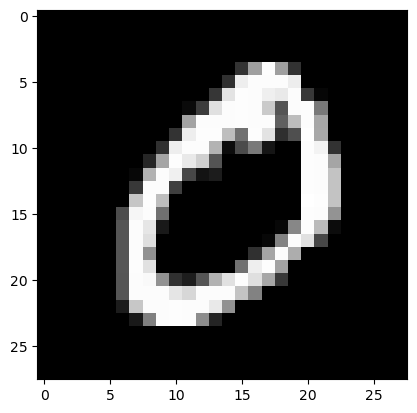

In [118]:
top = np.hstack((dataset[0][0].reshape(14, 14), dataset[1][0].reshape(14, 14)))
bottom = np.hstack((dataset[2][0].reshape(14, 14), dataset[3][0].reshape(14, 14)))
img = np.vstack((top, bottom))
plt.imshow(img, cmap="gray")

In [119]:
labels

array(['zero', 'zero', 'zero', ..., 'nine', 'nine', 'nine'], dtype='<U5')

In [113]:
mnist2_files_path = os.listdir("./MNIST_2")
mnist2_files_path.sort()
dataset2 = []
labels2 = []
for file in mnist2_files_path:
    view = []
    class_names = []
    with open(f"./MNIST_2/{file}", 'r') as f:
        for line in f.readlines():
            arr = line.split()
            class_names.append(arr[0])
            view.append([l.split(':')[1] for l in arr[1:]])
    dataset2.append(np.array(view, dtype='int'))
    labels2.append(np.array(class_names, dtype='object'))

In [2]:
nus_features_files_path = os.listdir("./NUS-WIDE-OBJECT/low level features")
nus_features_files_path.sort()
nus_labels_files_path = os.listdir("./NUS-WIDE-OBJECT/ground truth")
nus_labels_files_path.sort()

In [39]:
len(nus_labels_files_path)

62

In [52]:
train_set, test_set = {}, {}
y_train, y_test = [], []

for file in  nus_features_files_path:
    view = file.split('_')[1].split('.')[0]
    with open(f"./NUS-WIDE-OBJECT/low level features/{file}", 'r') as f:
        data = []
        for line in f.readlines():
            data.append([float(x) for x in line.split()])
        if 'Train' in file:
            train_set[view] = np.array(data)
        else:
            test_set[view] = np.array(data)

for file in nus_labels_files_path:
    with open(f"./NUS-WIDE-OBJECT/ground truth/{file}", 'r') as f:
        data = []
        for line in f.readlines():
            data.append(int(line))
        if 'Train' in file:
            y_train.append(data)
        else:
            y_test.append(data)

y_train = np.array(y_train).transpose()
y_test = np.array(y_test).transpose()

In [53]:
for k, v in train_set.items():
    print(k, v.shape)
print(f"{y_train.shape=}  {y_test.shape=}")

CH (17928, 65)
CM55 (17928, 226)
CORR (17928, 145)
EDH (17928, 74)
WT (17928, 129)
y_train.shape=(17928, 31)  y_test.shape=(12072, 31)


In [54]:
assert np.all(y_train.sum(axis=1) == np.ones(y_train.shape[0]))

AssertionError: 

In [64]:
j =  0
for i, f in enumerate(nus_labels_files_path):
    if "Train" in f:
        if y_train[200, j] == 1:
            print(f)
        j += 1

planeTrain.txt
sunTrain.txt
vehicleTrain.txt


In [83]:
np.where(y_train.sum(axis=0) > 2000)

(array([13, 28]),)

In [86]:
y_train[:, 28].sum() > 2000

True

In [87]:
y_train[:, np.where(y_train.sum(axis=0) > 2000)[0]].shape

(17928, 2)